In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from os import path
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
style.use('fivethirtyeight')



In [2]:
senate = pd.read_csv('./data/senate_processed.csv')

In [3]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio,text_processed
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667,franni since al birthday since working hard wa...
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321,profoundly troubling would president trump giv...
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418,clearer need independent investigation preside...
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766,troubling news ag session involved firing jeff...
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612,troubling news probably know president trump f...


In [4]:
senate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219539 entries, 0 to 219538
Data columns (total 11 columns):
created_at        219539 non-null object
id_str            219539 non-null float64
reply_count       219539 non-null float64
retweet_count     219539 non-null float64
text              219539 non-null object
user              219539 non-null object
name              219539 non-null object
state             219539 non-null object
party             219539 non-null object
the_ratio         219539 non-null float64
text_processed    219536 non-null object
dtypes: float64(4), object(7)
memory usage: 18.4+ MB


In [5]:
# dropping null values
senate.dropna(inplace=True)
senate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219536 entries, 0 to 219538
Data columns (total 11 columns):
created_at        219536 non-null object
id_str            219536 non-null float64
reply_count       219536 non-null float64
retweet_count     219536 non-null float64
text              219536 non-null object
user              219536 non-null object
name              219536 non-null object
state             219536 non-null object
party             219536 non-null object
the_ratio         219536 non-null float64
text_processed    219536 non-null object
dtypes: float64(4), object(7)
memory usage: 20.1+ MB


In [6]:
# creating ratio quartiles
senate['ratio_quartile'] = pd.qcut(senate['the_ratio'], 4, labels=False)

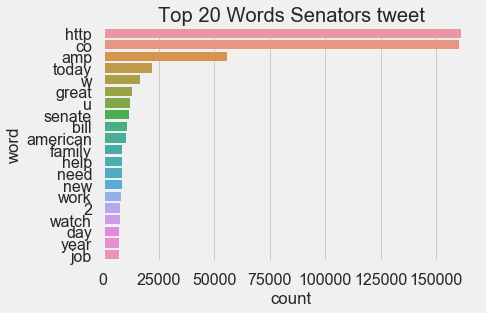

In [180]:
summary_words_list = []
for texts in senate['text_processed']:
    for word in texts.split():
        summary_words_list.append(word)
        
        
count_summary_words = Counter(summary_words_list)
top_summary_words = pd.DataFrame.from_dict(count_summary_words, 
                                           orient='index').reset_index().sort_values(0, ascending=False).head(20)

new_cols = [u'word', u'count']
top_summary_words.columns = new_cols

ax = plt.axes()
sns.barplot(x="count", y="word", data=top_summary_words)
ax.set_title('Top 20 Words Senators tweet')
plt.show();

In [8]:
# Creating dataframes for each party
Democratic = senate[senate['party'] == 'Democratic']
Republican = senate[senate['party'] == 'Republican']
Independent = senate[senate['party'] == 'Independent']

### Top words tweeted by senators by partisanship.

In [308]:
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("u")
stopwords.add("w")
stopwords.add("bit")
stopwords.add("ly")

In [309]:
# fitting and transforming CV on democratic tweets
cv_dem = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(1,1))
cv_dem.fit(Democratic['text_processed'])
dem_words = cv_dem.transform(Democratic['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(dem_words).toarray()[0]
dem_word_df = pd.DataFrame(frequencies, index=cv_dem.get_feature_names(), 
                             columns=['frequency'])

dem_word_df.index.rename('Democratic', inplace=True)
top_dem_words = pd.DataFrame(dem_word_df.sort_values('frequency', ascending=False).head(20)).reset_index()
top_dem_words

,Democratic,frequency
0,today,9221
1,great,5622
2,bill,4907
3,need,4716
4,family,4662
5,american,4649
6,senate,4537
7,help,4520
8,new,4280
9,work,4210


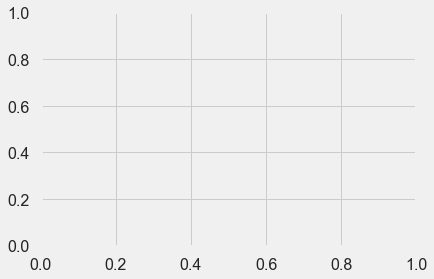

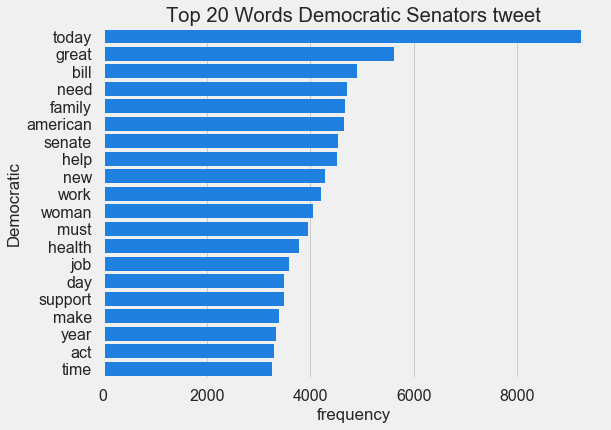

In [410]:
fig, ax = plt.subplots();
plt.figure(figsize=(8,6))
ax = plt.axes()
sns.barplot(x="frequency", y="Democratic", data=top_dem_words, color='#0080FF')
ax.set_title('Top 20 Words Democratic Senators tweet')
plt.show();

In [312]:
# fitting and transforming CV on democratic tweets
cv_rep = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(1,1))
cv_rep.fit(Republican['text_processed'])
rep_words = cv_rep.transform(Republican['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(rep_words).toarray()[0]
rep_word_df = pd.DataFrame(frequencies, index=cv_rep.get_feature_names(), 
                             columns=['frequency'])

rep_word_df.index.rename('Republican', inplace=True)
top_rep_words = pd.DataFrame(rep_word_df.sort_values('frequency', ascending=False).head(20)).reset_index()
top_rep_words

,Republican,frequency
0,today,12224
1,great,7202
2,senate,6751
3,bill,5434
4,american,4864
5,watch,4773
6,obamacare,4219
7,new,3884
8,help,3881
9,thanks,3651


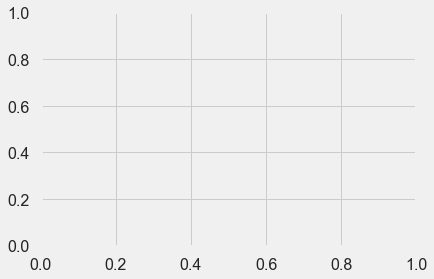

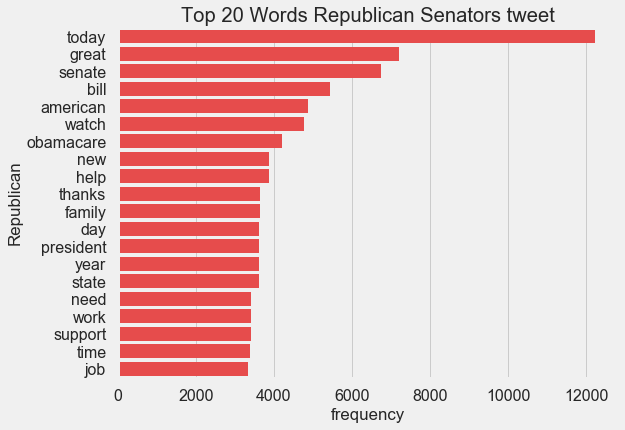

In [413]:
fig, ax = plt.subplots();
plt.figure(figsize=(8,6))
ax = plt.axes()
sns.barplot(x="frequency", y="Republican", data=top_rep_words, color='#FF3333')
ax.set_title('Top 20 Words Republican Senators tweet')
plt.show();

In [313]:
# fitting and transforming CV on democratic tweets
cv_ind = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(1,1))
cv_ind.fit(Independent['text_processed'])
ind_words = cv_ind.transform(Independent['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(ind_words).toarray()[0]
ind_word_df = pd.DataFrame(frequencies, index=cv_ind.get_feature_names(), 
                             columns=['frequency'])

ind_word_df.index.rename('Independent', inplace=True)
top_ind_words = pd.DataFrame(ind_word_df.sort_values('frequency', ascending=False).head(20)).reset_index()
top_ind_words

,Independent,frequency
0,mepolitics,749
1,people,681
2,american,515
3,today,459
4,must,451
5,maine,401
6,trump,319
7,country,316
8,need,313
9,million,288


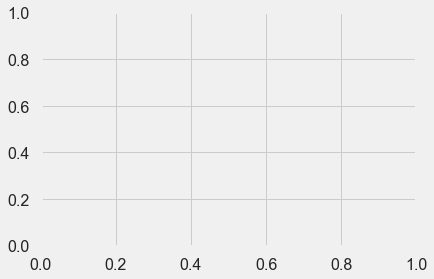

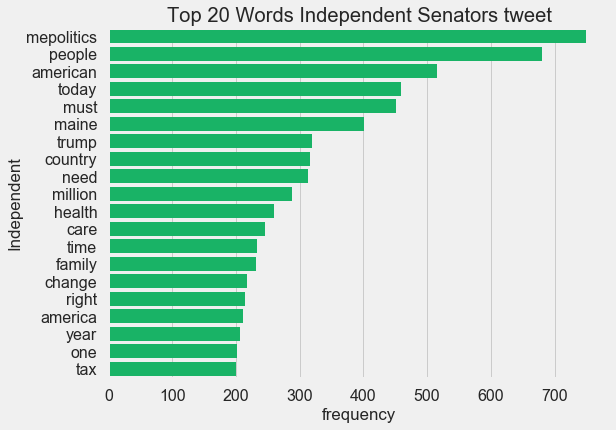

In [409]:
fig, ax = plt.subplots();
plt.figure(figsize=(8,6))
ax = plt.axes()
sns.barplot(x="frequency", y="Independent", data=top_ind_words, color='#00cc66')
ax.set_title('Top 20 Words Independent Senators tweet')
plt.show();

### Top bigrams tweeted by senators by partisanship.

In [315]:
# Added more stopwords ontop of those added to the text_process function
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("u")
stopwords.add("w")
stopwords.add("bit")
stopwords.add("ly")

# fitting and transforming CV on democratic tweets
cv_dem = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(2,2))
cv_dem.fit(Democratic['text_processed'])
dem_bigrams = cv_dem.transform(Democratic['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(dem_bigrams).toarray()[0]
dem_bigram_df = pd.DataFrame(frequencies, index=cv_dem.get_feature_names(), 
                             columns=['frequency'])

dem_bigram_df.index.rename('Democratic', inplace=True)
top_dem_bigrams = pd.DataFrame(dem_bigram_df.sort_values('frequency', ascending=False).head(30)).reset_index()
top_dem_bigrams

,Democratic,frequency
0,health care,1462
1,senate floor,830
2,watch live,684
3,make sure,576
4,gov hassan,575
5,last night,541
6,governor hassan,534
7,looking forward,510
8,president trump,484
9,op ed,469


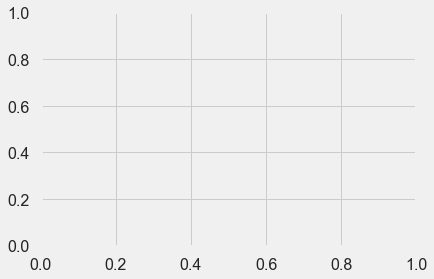

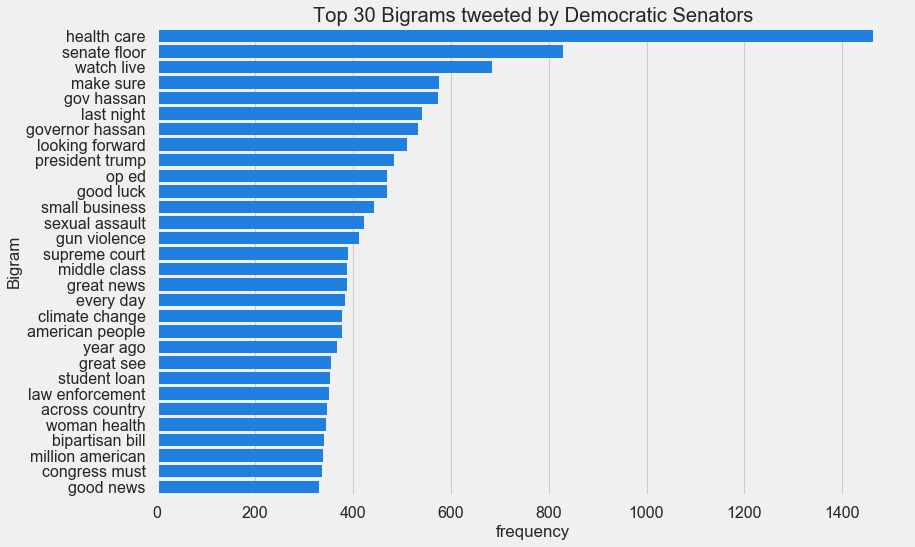

In [411]:
fig, ax = plt.subplots();
plt.figure(figsize=(12,8));
ax = plt.axes();
sns.barplot(x="frequency", y="Democratic", data=top_dem_bigrams, color='#0080FF');
ax.set_title('Top 30 Bigrams tweeted by Democratic Senators');
ax.set_ylabel("Bigram");
plt.show();

In [336]:
# fitting and transforming CV on republican tweets
cv_rep = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(2,2))
cv_rep.fit(Republican['text_processed'])
rep_bigrams = cv_rep.transform(Republican['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(rep_bigrams).toarray()[0]
rep_bigram_df = pd.DataFrame(frequencies, index=cv_rep.get_feature_names(), 
                             columns=['frequency'])

rep_bigram_df.index.rename('Republican', inplace=True)
top_rep_bigrams = pd.DataFrame(rep_bigram_df.sort_values('frequency', ascending=False).head(30)).reset_index()
top_rep_bigrams

,Republican,frequency
0,senate floor,1041
1,health care,1024
2,op ed,855
3,looking forward,841
4,watch live,792
5,last night,722
6,president obama,709
7,look forward,663
8,american people,658
9,town hall,651


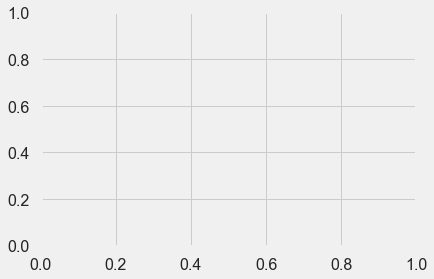

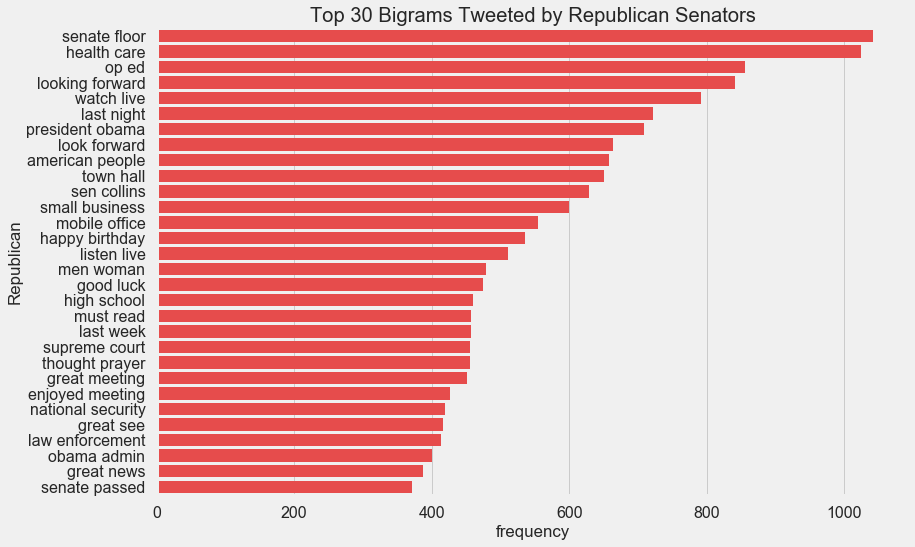

In [414]:
fig, ax = plt.subplots();
plt.figure(figsize=(12,8));
ax = plt.axes();
sns.barplot(x="frequency", y="Republican", data=top_rep_bigrams, color='#FF3333');
ax.set_title('Top 30 Bigrams Tweeted by Republican Senators');
plt.show();

In [338]:
# fitting and transforming CV on independent tweets
cv_ind = CountVectorizer(stop_words=stopwords, strip_accents='ascii', ngram_range=(2,2))
cv_ind.fit(Independent['text_processed'])
ind_bigrams = cv_ind.transform(Independent['text_processed'])

# Creating a dataframe containing bigram frequency
frequencies = sum(ind_bigrams).toarray()[0]
ind_bigram_df = pd.DataFrame(frequencies, index=cv_ind.get_feature_names(), 
                             columns=['frequency'])
ind_bigram_df.index.rename('Independent', inplace=True)
top_ind_bigrams = pd.DataFrame(ind_bigram_df.sort_values('frequency', ascending=False).head(30)).reset_index()
top_ind_bigrams

,Independent,frequency
0,health care,183
1,climate change,133
2,wall street,97
3,american people,95
4,fossil fuel,91
5,social security,90
6,united state,79
7,minimum wage,65
8,tax break,60
9,million people,57


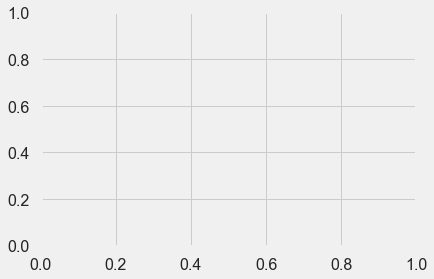

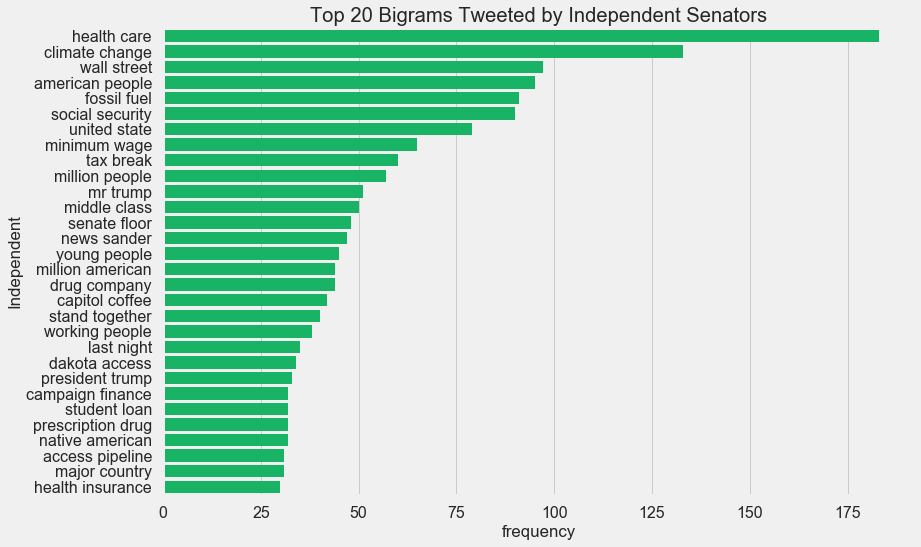

In [415]:
fig, ax = plt.subplots();
plt.figure(figsize=(12,8));
ax = plt.axes();
sns.barplot(x="frequency", y="Independent", data=top_ind_bigrams, color='#00cc66');
ax.set_title('Top 20 Bigrams Tweeted by Independent Senators');
plt.show();

### Distribution of "The Twitter Ratio"

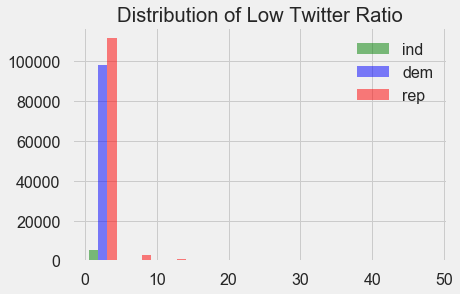

In [298]:
ind = senate[(senate.party == 'Independent')&(senate.the_ratio < 50)]['the_ratio'].values
dem = senate[(senate.party == 'Democratic')&(senate.the_ratio < 50)]['the_ratio'].values
rep = senate[(senate.party == 'Republican')&(senate.the_ratio < 50)]['the_ratio'].values

labels= ["ind","dem", "rep"]
plt.hist([ind, dem, rep], color=['g','b', 'r'], 
         alpha=0.5, 
         bins=10, 
         label=labels);
plt.title('Distribution of Low Twitter Ratio')
plt.legend()

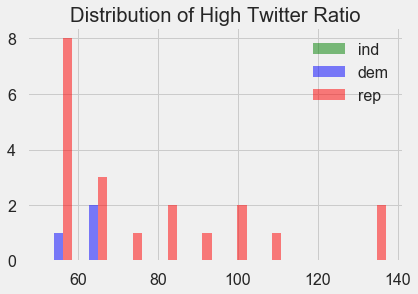

In [299]:
ind = senate[(senate.party == 'Independent')&(senate.the_ratio > 50)]['the_ratio'].values
dem = senate[(senate.party == 'Democratic')&(senate.the_ratio > 50)]['the_ratio'].values
rep = senate[(senate.party == 'Republican')&(senate.the_ratio > 50)]['the_ratio'].values


labels= ["ind","dem", "rep"]
plt.hist([ind, dem, rep], color=['g','b', 'r'], 
         alpha=0.5, 
         bins=10, 
         label=labels);
plt.title('Distribution of High Twitter Ratio')
plt.legend()


### Creating Partisan Wordclouds

In [259]:
# Democratic WordCloud
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("u")
stopwords.add("w")

data = Democratic['text_processed']

wordcloud = WordCloud(
                          width=400,
                          height= 200,
                          background_color='#FFD700',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40,
                          colormap='Blues',
                          random_state=42
                         ).generate(str(data))

print(wordcloud)
fig = plt.figure(1, figsize=(10,7),dpi=1200)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Democratic Words')
plt.show()



In [420]:
# Republican WordCloud
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("u")
stopwords.add("w")

data = Republican['text_processed']

wordcloud = WordCloud(
                          background_color='#FFD700',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40,
                          colormap="Reds",
                          random_state=42
                         ).generate(str(data))

print(wordcloud)
fig = plt.figure(1, figsize=(10,7), dpi=1200)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Republican Words')
plt.show()

In [258]:
# Independent WordCloud
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("co")
stopwords.add("amp")
stopwords.add("u")
stopwords.add("w")

data = Independent['text_processed']

wordcloud = WordCloud(
                          background_color='#FFD700',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40,
                          colormap='Greens',
                          random_state=42
                         ).generate(str(data))

print(wordcloud)
fig = plt.figure(1, figsize=(10,7), dpi=1200)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Independent Words')
plt.show()

In [ ]:
## tweet length/ avg word length/ using set to see uniqe words

### Distribution of  Senator Tweet Lengths

In [360]:
# creating a new feature for tweet length
tweet_lenght = []
for each in senate['text']:
    tweet_lenght.append(len(each))

senate['tweet_length'] = tweet_lenght

Text(0.5,1,'Distribution of tweet lenght')

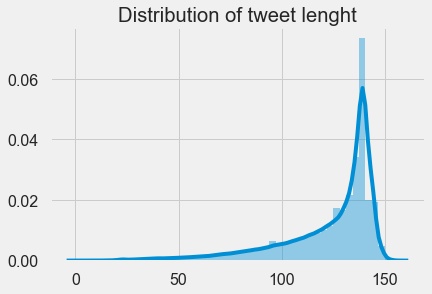

In [284]:
sns.distplot(senate['tweet_length'].values)
plt.title("Distribution of tweet lenght")

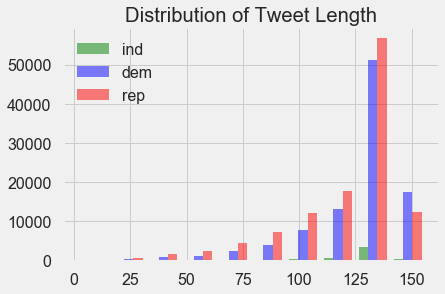

In [295]:
ind = senate[senate.party == 'Independent']['tweet_length'].values
dem = senate[senate.party == 'Democratic']['tweet_length'].values
rep = senate[senate.party == 'Republican']['tweet_length'].values


labels= ["ind","dem", "rep"]
plt.hist([ind, dem, rep], color=['g','b', 'r'], 
         alpha=0.5, 
         bins=10, 
         label=labels);
plt.title('Distribution of Tweet Length')
plt.legend()

In [370]:
tweet_freq = pd.DataFrame(senate['party'].value_counts()).reset_index()

In [377]:
tweet_freq = tweet_freq.rename(columns={'index':'party', 'party':'count'})

Text(0.5,1,'Number of Tweets by Party')

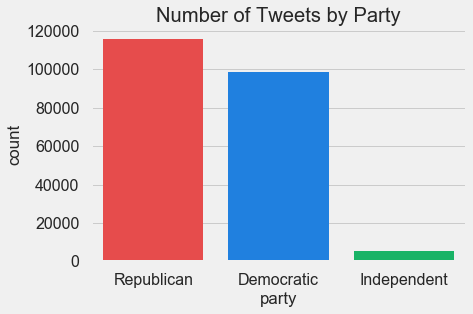

In [418]:
sns.barplot(x="party", y="count", data=tweet_freq, palette=['#FF3333','#0080FF', '#00cc66']);
plt.title('Number of Tweets by Party')


In [ ]:
, 